In [265]:
import requests
import json 
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [266]:
def querystring(start=0, elems=100) -> dict:
    return {"q":"alfa giulia","c":"2","t":"s","qso":"false","shp":"false","urg":"false","sort":"datedesc","lim":f"{elems}","start":f"{start}"}

In [267]:
url = "https://hades.subito.it/v1/search/items"

payload = ""
headers = {
    "accept": "application/json, text/plain, */*",
    "accept-language": "it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7",
    "origin": "https://www.subito.it",
    "priority": "u=1, i",
    "referer": "https://www.subito.it/",
    "sec-ch-ua": '"Google Chrome";v="131", "Chromium";v="131", "Not_A Brand";v="24"',
    "sec-ch-ua-mobile": "?1",
    "sec-ch-ua-platform": '"Android"',
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-site",
    "user-agent": "Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Mobile Safari/537.36",
    "x-subito-channel": "web",
    "x-subito-environment-id": "c79e6360-ea6b-431f-9b65-3be9d52c7b84"
}

In [268]:
try:
    i = 0
    elems = 100
    data_rows = []
    
    more_results = True

    while more_results:
        response = requests.request("GET", url, data=payload, headers=headers, params=querystring(i, elems))

        json_response = response.json()  # Parse response text as JSON
        # Print the keys of the JSON response
        ads = json_response['ads']

        if len(ads) < elems:
            more_results = False

        for ad in ads:
            # Initialize a row with the necessary fields
            row = [
                ad.get('subject', ''),
                ad.get('body', ''),
                ad['advertiser'].get('name', ''),
                ad['advertiser'].get('company', ''),
                ad['geo']['town'].get('value', ''),
                ad['geo']['city'].get('short_name', ''),
                ad['urls'].get('default', '')
            ]

            features = ad.get('features', [])
            
            # Extract specific features
            feature_values = {
                'Cubic_capacity' : None,
                'Pollution' : None,
                'Power' : None,
                'Doors': None,
                'Fuel': None,
                'Vehicle_status': None,
                'Vat_deductible': None,
                'Gearbox': None,
                'Price': None,
                'Car_type': None,
                'Seats': None,
                'Mileage': None,
                'Mileage_scalar': None,
                'Year': None,
                'Month': None,
                'Register_date': None
            }
            
            for feat in features:
                if feat['uri'] in ['/power', '/cubic_capacity', '/pollution', '/doors', '/fuel', '/vehicle_status', '/vat_deductible', '/gearbox', 
                                '/price', '/car_type', '/seats', '/mileage', '/mileage_scalar', 
                                '/year', '/month', '/register_date']:
                    label = feat['uri'].replace('/', '').capitalize()
                    value = feat['values'][0]['value']

                    if feat['uri'] == '/mileage_scalar':
                        value = float(value.replace(' Km', '').replace('.', ''))
                    if feat['uri'] == '/price':
                        value = float(value.replace(' €', '').replace('.', ''))
                    if feat['uri'] == '/cubic_capacity':
                        value = float(value.replace(' cc', '').replace('.', ''))
                    if feat['uri'] == '/power':
                        value = float(value.split(' kW / ')[1].split(' Cv')[0])
                    
                    feature_values[label] = value
                
                if feat['uri'] == '/car':
                    for value in feat['values']:
                        feature_values[value["label"]] = value['value']

            if 'Versione' in feature_values.keys():
                versione = feature_values['Versione'].lower()

                if not feature_values['Power']:
                    
                        if versione:
                            if 'cv' in versione:
                                words = versione.split()
                                if "cv" in words:
                                    index = words.index("cv")
                                    if index > 0:
                                        feature_values['Power'] = words[index - 1]
            
                if not feature_values['Cubic_capacity']:
                    # Pattern to find a number followed by a decimal (e.g., 2.0 or 2.2)
                    pattern = r'\b\d+\.\d+\b'

                    # Extract the floatable values from each description
                    floatable_values = [re.search(pattern, description).group() for description in versione.split() if re.search(pattern, description)]
                    if len(floatable_values) == 1:
                        feature_values['Cubic_capacity'] = float(floatable_values[0])*1000
            
            if feature_values['Year'] == None:
                if feature_values['Register_date']:
                    feature_values['Year'] = feature_values['Register_date'][-4:]
            
            if feature_values['Mileage_scalar'] == None:
                if feature_values['Mileage']:
                    feature_values['Mileage_scalar'] = feature_values['Mileage'].split("- ")[1]
                
            # Extend the row with feature values
            row.extend(feature_values.values())
            if len(row) < 26:
                # aggiungo None alla versione, se non c'è 
                row.append(None)

            # Append the row to the list
            data_rows.append(row)
        i += elems
        
    # Convert list of rows to NumPy array
    np_array = np.array(data_rows, dtype=object)
    #print(np_array)

    columns = [
    'Subject', 'Body', 'Advertiser Name', 'Company', 
    'Comune', 'Province', 'Url',
    'Cilindrata', 'Emissioni', 'Potenza', 'Porte', 'Carburante', 'Tipo di veicolo', 'Iva deducibile', 
    'Cambio', 'Prezzo', 'Tipo di macchina', 'Posti', 
    'Km range', 'Km', 'Anno di immatricolazione', 
    'Mese di immatricolazione', 'Immatricolazione Date', 'Marca', 'Modello', 'Versione'
    ]

    df = pd.DataFrame(np_array, columns=columns)
        
except json.JSONDecodeError:
    print("Failed to parse JSON response")

In [269]:
len(df)

1511

In [270]:
df.head()

,Subject,Body,Advertiser Name,Company,Comune,Province,Url,Cilindrata,Emissioni,Potenza,Porte,Carburante,Tipo di veicolo,Iva deducibile,Cambio,Prezzo,Tipo di macchina,Posti,Km range,Km,Anno di immatricolazione,Mese di immatricolazione,Immatricolazione Date,Marca,Modello,Versione
0,Giulietta 1.4 turbo benzina 120cv,Giulietta 1.4 turbo benzina 120cv\n\nVendo la ...,Massimo,False,Milano,MI,https://www.subito.it/auto/giulietta-1-4-turbo...,1400.0,Euro 6,120,4/5,Benzina,Usato,No,Manuale,13500.0,Berlina,5,75.000 - 79.999,75500.0,2019,Gennaio,01/2019,ALFA ROMEO,Giulietta (2010-21),Giulietta 1.4 Turbo 120 CV
1,Alfa Romeo Giulia 2.2 Turbodiesel 180 CV AT8 S...,Alfa Romeo Giulia 2.2 - 180 Cv- 8 marce AT PRE...,S.B.C. Automobili Leone,True,Pachino,SR,https://www.subito.it/auto/alfa-romeo-giulia-2...,2143.0,Euro 6,180.0,4/5,Diesel,Usato,None,Automatico,15500.0,Berlina,5,150.000 - 159.999,153000.0,2016,Novembre,11/2016,ALFA ROMEO,Giulia (2016),Giulia 2.2 Turbodiesel 180 CV AT8 Super
2,ALFA ROMEO Giulia 2.2 TD 180CV AT8 SUPER NAVI ...,Chilometraggio: 186046\nCondizioni: usato\nImm...,FAZZONE S.R.L.,True,Piana di Monte Verna,CE,https://www.subito.it/auto/alfa-romeo-giulia-2...,2143.0,Euro 6,180.0,4/5,Diesel,Usato,None,Automatico,16990.0,Berlina,5,180.000 - 189.999,186046.0,2018,Aprile,04/2018,ALFA ROMEO,Giulia (2016),Giulia 2.2 Turbodiesel 180 CV AT8 Super
3,Alfa Romeo Giulia 2.2 Turbodiesel 150 CV 12 ME...,"Al Super Prezzo di € 17950,00\n\nCHIAMA 380 34...",TOP CAR MILLIONAIRE DI SAV & SHA S.R.L.S.,True,Sant'Antonio Abate,NA,https://www.subito.it/auto/alfa-romeo-giulia-2...,2143.0,Euro 6,160.0,4/5,Diesel,Usato,None,Automatico,17950.0,Berlina,5,65.000 - 69.999,65000.0,2020,Maggio,05/2020,ALFA ROMEO,Giulia (2016),Giulia 2.2 Turbodiesel 160 CV AT8 Executive
4,Alfa Romeo Giulia 2.2 TURBODIESEL 160 cv. AT8 ...,Auto in ottime condizioni sia di motore che di...,Auto DATO s.r.l,True,Gesualdo,AV,https://www.subito.it/auto/alfa-romeo-giulia-2...,2143.0,Euro 6,160.0,4/5,Diesel,Usato,Sì,Automatico,19400.0,Berlina,5,100.000 - 109.999,101000.0,2019,Settembre,09/2019,ALFA ROMEO,Giulia (2016),Giulia 2.2 Turbodiesel 160 CV AT8 Business


In [271]:
# Specify the columns you want to keep
columns_to_keep = [
    'Province',
    'Cilindrata', 'Emissioni', 'Potenza', 'Porte', 'Carburante', 'Tipo di veicolo', 'Iva deducibile',
    'Tipo di macchina', 'Posti', 'Km', 'Anno di immatricolazione', 'Marca', 'Prezzo'
]

# Create a new DataFrame with only the specified columns
df_filtered = df[columns_to_keep]
df_filtered.loc[:, 'Prezzo'] = pd.to_numeric(df_filtered['Prezzo'], errors='coerce')
df_filtered.loc[:, 'Anno di immatricolazione'] = pd.to_numeric(df_filtered['Anno di immatricolazione'], errors='coerce').fillna(2000).astype('Int64')
df_filtered.loc[:, 'Posti'] = pd.to_numeric(df_filtered['Posti'], errors='coerce').fillna(5).astype('Int64')
df_filtered['Km'] = pd.to_numeric(df_filtered['Km'], errors='coerce').fillna(pd.to_numeric(df_filtered['Km'], errors='coerce').mean())
df_filtered.loc[:, 'Iva deducibile'] = df_filtered['Iva deducibile'].map(lambda x: bool(x) if pd.notnull(x) else False)
df_filtered['Potenza'] = pd.to_numeric(df_filtered['Potenza'], errors='coerce').fillna(pd.to_numeric(df_filtered['Potenza'], errors='coerce').mean())
df_filtered['Cilindrata'] = pd.to_numeric(df_filtered['Cilindrata'], errors='coerce').fillna(pd.to_numeric(df_filtered['Cilindrata'], errors='coerce').mean())

# Initialize LabelEncoder
encoder = LabelEncoder()

# Fit and transform the column
df_filtered['Province'] = encoder.fit_transform(df['Province'])
df_filtered['Emissioni'] = encoder.fit_transform(df['Emissioni'])
df_filtered['Porte'] = encoder.fit_transform(df['Porte'])
df_filtered['Carburante'] = encoder.fit_transform(df['Carburante'])
df_filtered['Tipo di veicolo'] = encoder.fit_transform(df['Tipo di veicolo'])
df_filtered['Tipo di macchina'] = encoder.fit_transform(df['Tipo di macchina'])
df_filtered['Marca'] = encoder.fit_transform(df['Marca'])

df_filtered.head()


C:\Users\andrea.panico01\AppData\Local\Temp\ipykernel_1384\1735441545.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'Prezzo'] = pd.to_numeric(df_filtered['Prezzo'], errors='coerce')
C:\Users\andrea.panico01\AppData\Local\Temp\ipykernel_1384\1735441545.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'Anno di immatricolazione'] = pd.to_numeric(df_filtered['Anno di immatricolazione'], errors='coerce').fillna(2000).astype('Int64')
C:\Users\andrea.panico01\AppDat

,Province,Cilindrata,Emissioni,Potenza,Porte,Carburante,Tipo di veicolo,Iva deducibile,Tipo di macchina,Posti,Km,Anno di immatricolazione,Marca,Prezzo
0,51,1400.0,5,120.0,1,1,2,True,1,5,75500.0,2019,0,13500.0
1,85,2143.0,5,180.0,1,2,2,False,1,5,153000.0,2016,0,15500.0
2,21,2143.0,5,180.0,1,2,2,False,1,5,186046.0,2018,0,16990.0
3,56,2143.0,5,160.0,1,2,2,False,1,5,65000.0,2020,0,17950.0
4,8,2143.0,5,160.0,1,2,2,True,1,5,101000.0,2019,0,19400.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


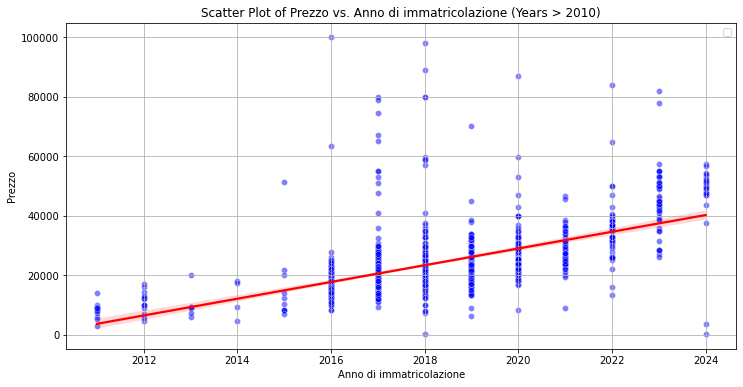

In [272]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'Anno di immatricolazione' and 'Prezzo' to numeric types, coercing errors to NaN
df['Anno di immatricolazione'] = pd.to_numeric(df['Anno di immatricolazione'], errors='coerce')
df['Prezzo'] = pd.to_numeric(df['Prezzo'], errors='coerce')

# Drop rows where 'Anno di immatricolazione' or 'Prezzo' is NaN
df = df.dropna(subset=['Anno di immatricolazione', 'Prezzo'])

# Filter for years greater than 2010 and limit 'Prezzo' to < 100,000
df = df[df['Anno di immatricolazione'] > 2010]
df = df[df['Prezzo'] < 100000]

# Sort the DataFrame by 'Anno di immatricolazione'
df = df.sort_values(by='Anno di immatricolazione')

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Anno di immatricolazione', y='Prezzo', data=df, color='blue', alpha=0.5)
sns.regplot(x='Anno di immatricolazione', y='Prezzo', data=df, scatter=False, color='red', line_kws={'label': 'Trend Line'})
plt.title('Scatter Plot of Prezzo vs. Anno di immatricolazione (Years > 2010)')
plt.xlabel('Anno di immatricolazione')
plt.ylabel('Prezzo')
plt.legend()
plt.grid(True)
plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


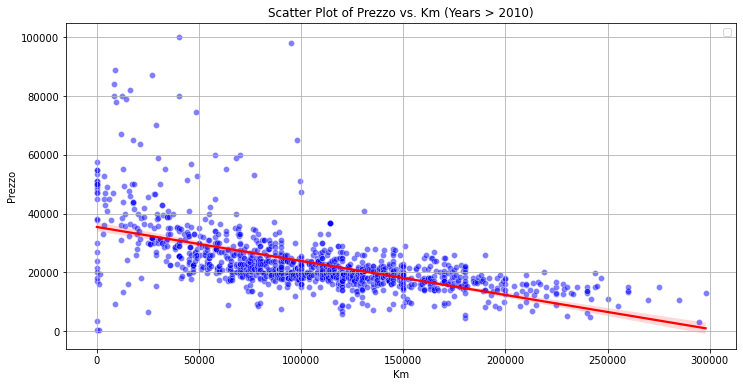

In [273]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'Anno di immatricolazione' and 'Prezzo' to numeric types, coercing errors to NaN
df['Km'] = pd.to_numeric(df['Km'], errors='coerce')
df['Prezzo'] = pd.to_numeric(df['Prezzo'], errors='coerce')

# Drop rows where 'Anno di immatricolazione' or 'Prezzo' is NaN
df = df.dropna(subset=['Km', 'Prezzo'])

df = df[df['Km'] < 400000]

# Filter for years greater than 2010 and limit 'Prezzo' to < 100,000
df = df[df['Prezzo'] < 100000]

# Sort the DataFrame by 'Anno di immatricolazione'
df = df.sort_values(by='Km')

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Km', y='Prezzo', data=df, color='blue', alpha=0.5)
sns.regplot(x='Km', y='Prezzo', data=df, scatter=False, color='red', line_kws={'label': 'Trend Line'})
plt.title('Scatter Plot of Prezzo vs. Km (Years > 2010)')
plt.xlabel('Km')
plt.ylabel('Prezzo')
plt.legend()
plt.grid(True)
plt.show()


In [282]:
df_filtered = df_filtered.dropna()
df_filtered = df_filtered[df_filtered['Prezzo'] < 100000]

X = df_filtered.drop(columns=['Prezzo'])
y = df_filtered['Prezzo']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Print model coefficients and intercept
#print(f"Coefficients: {model.coef_}")
#print(f"Intercept: {model.intercept_}")

Mean Squared Error: 69868401.44501032
R-squared: 0.647426157928247


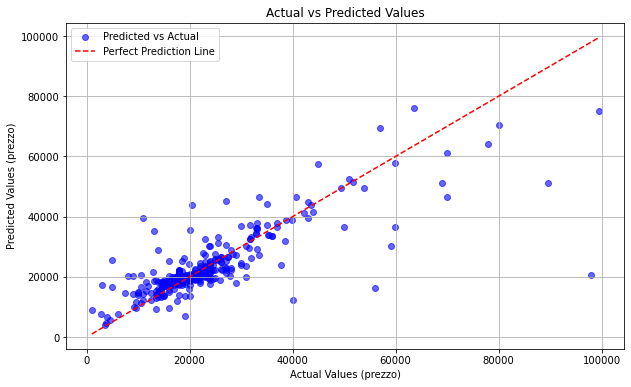

In [283]:
import matplotlib.pyplot as plt

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Values (prezzo)')
plt.ylabel('Predicted Values (prezzo)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
